# 데이터 기본 설정

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PowerTransformer, StandardScaler, OneHotEncoder
import gc

cv_str_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='AppleGothic'  #Mac용
#matplotlib.rcParam['font.family']='Malgun Gothic' 윈도우 용
matplotlib.rcParams['font.size']=15 #글자 크기
matplotlib.rcParams['axes.unicode_minus']=False #한글 폰트 사용 시, 마이너스 글자가 깨지는 현상을 해결


In [3]:
train = pd.read_csv("train_common.csv")
test = pd.read_csv("test_common.csv")
submission = pd.read_csv("sample_submission.csv")
quality_ = train[["quality"]]

train.shape, test.shape, submission.shape

((5483, 14), (1000, 13), (1000, 2))

In [4]:
type_dict = {
    0:"white",
    1:"red"
}
train["종류"] = train["종류"].map(type_dict)
test["종류"] = test["종류"].map(type_dict)

train.shape, test.shape

((5483, 14), (1000, 13))

In [5]:
del type_dict
gc.collect();

In [6]:
def resumtable(df):
    summary = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:"dtypes"})
    summary["결측치 갯수"] = df.isnull().sum().values
    summary["고윳값 갯수"] = df.nunique().values
    summary["첫번째 값"] = df.iloc[0].values
    summary["두번째 값"] = df.iloc[1].values
    summary["세번째 값"] = df.iloc[2].values
    
    return summary

In [7]:
resumtable(train)

,index,dtypes,결측치 갯수,고윳값 갯수,첫번째 값,두번째 값,세번째 값
0,index,int64,0,5483,0,1,2
1,산도,float64,0,106,5.6,8.8,7.9
2,휘발성산,float64,0,179,0.695,0.61,0.21
3,시트르산,float64,0,84,0.06,0.14,0.39
4,잔여당분,float64,0,307,6.8,2.4,2.0
5,염화물,float64,0,203,0.042,0.067,0.057
6,독립_이산화황,float64,0,126,9.0,10.0,21.0
7,총_이산화황,float64,0,269,84.0,42.0,138.0
8,밀도,float64,0,969,0.99432,0.9969,0.99176
9,수소이온농도,float64,0,107,3.44,3.19,3.05


# 파생변수

## 와인 종류별 최대, 최저 도수 및 평균, 표준편차 구하기 < cv점수는 변화없는데 데이콘 점수 떡상

In [8]:
agg_list = [
    # ("종류별_도수_min", "min"),
    # ("종류별_도수_max", "max"),
    # ("종류별_최대최저_도수차이", lambda x: x.max() - x.min()),
    ("종류별_도수_mean", "mean"),
    ("종류별_도수_std", "std")
]
tmp = train.groupby("종류")["도수"].agg(agg_list).reset_index()

train = train.merge(tmp, how="left", on="종류")
test = test.merge(tmp, how="left", on="종류")

train = train.drop(columns="quality")
train = pd.concat([train, quality_], axis=1)

train.shape, test.shape

((5483, 16), (1000, 15))

In [9]:
del agg_list, tmp
gc.collect();

## 와인 종류별 최대, 최저 밀도 및 평균, 표준편차 구하기 < 점수 하락

In [10]:
# agg_list = [
#     ("종류별_밀도_min", "min"),
#     ("종류별_밀도_max", "max"),
#     ("종류별_최대최저_밀도차이", lambda x: x.max() - x.min()),
#     ("종류별_밀도_mean", "mean"),
#     ("종류별_밀도_std", "std")
# ]
# tmp = train.groupby("종류")["밀도"].agg(agg_list).reset_index()

# train = train.merge(tmp, how="left", on="종류")
# test = test.merge(tmp, how="left", on="종류")

# train = train.drop(columns="quality")
# train = pd.concat([train, quality_], axis=1)

# train.shape, test.shape

## 와인 종류별 최대, 최저 휘발성산 및 평균, 표준편차 구하기

In [11]:
# agg_list = [
#     ("종류별_휘발성산_min", "min"),
#     ("종류별_휘발성산_max", "max"),
#     ("종류별_최대최저_휘발성산차이", lambda x: x.max() - x.min()),
#     ("종류별_휘발성산_mean", "mean"),
#     ("종류별_휘발성산_std", "std")
# ]
# tmp = train.groupby("종류")["휘발성산"].agg(agg_list).reset_index()

# train = train.merge(tmp, how="left", on="종류")
# test = test.merge(tmp, how="left", on="종류")

# train = train.drop(columns="quality")
# train = pd.concat([train, quality_], axis=1)

# train.shape, test.shape

## 총_이산화황에대한 독립_이산화황의 비율

In [12]:
# train["독립_이산화황_비율"] = train["독립_이산화황"] / train["총_이산화황"]
# test["독립_이산화황_비율"] = test["독립_이산화황"] / test["총_이산화황"]

# train = train.drop(columns="quality")
# train = pd.concat([train, quality_], axis=1)

# train.shape, test.shape

## 당도 등급 구하기

In [13]:
# bins = [0,2,10,20,30,50,100]

# train["잔여당분_quantile"] = pd.cut(train["잔여당분"], bins = bins, right=False, labels=[1,2,3,4,5,6])
# test["잔여당분_quantile"] = pd.cut(train["잔여당분"], bins=bins, right=False, labels=[1,2,3,4,5,6])

# train = train.drop(columns="quality")
# train = pd.concat([train, quality_], axis=1)

# train.isnull().sum().sum(), test.isnull().sum().sum()

## "점성" 피처 만들기

In [15]:
train

,index,산도,휘발성산,시트르산,잔여당분,염화물,독립_이산화황,총_이산화황,밀도,수소이온농도,황산염,도수,종류,종류별_도수_mean,종류별_도수_std,quality
0,0,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white,10.527127,1.231358,5
1,1,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red,10.434081,1.065452,5
2,2,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white,10.527127,1.231358,5
3,3,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white,10.527127,1.231358,6
4,4,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white,10.527127,1.231358,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5478,5492,7.7,0.150,0.29,1.3,0.029,10.0,64.0,0.99320,3.35,0.39,10.1,white,10.527127,1.231358,5
5479,5493,6.3,0.180,0.36,1.2,0.034,26.0,111.0,0.99074,3.16,0.51,11.0,white,10.527127,1.231358,6
5480,5494,7.8,0.150,0.34,1.1,0.035,31.0,93.0,0.99096,3.07,0.72,11.3,white,10.527127,1.231358,7
5481,5495,6.6,0.410,0.31,1.6,0.042,18.0,101.0,0.99195,3.13,0.41,10.5,white,10.527127,1.231358,5


In [16]:
# train["점성"] = train["도수"]**2 + train["잔여당분"]**2
# test["점성"] = test["도수"]**2 + test["잔여당분"]**2

# train = train.drop(columns="quality")
# train = pd.concat([train, quality_], axis=1)

# train.shape, test.shape

((5483, 17), (1000, 16))

## 와인 종류별 최대, 최저 잔여당분 및 평균, 표준편차 구하기

In [4658]:
# agg_list = [
#     ("종류별_잔여당분_min", "min"),
#     ("종류별_잔여당분_max", "max"),
#     ("종류별_최대최저_잔여당분차이", lambda x: x.max() - x.min()),
#     ("종류별_잔여당분_mean", "mean"),
#     ("종류별_잔여당분_std", "std")
# ]
# tmp = train.groupby("종류")["잔여당분"].agg(agg_list).reset_index()

# train = train.merge(tmp, how="left", on="종류")
# test = test.merge(tmp, how="left", on="종류")

# train = train.drop(columns="quality")
# train = pd.concat([train, quality_], axis=1)

# train.shape, test.shape

## 산도에 대한 시트르산, 휘발성산의 비율

In [4659]:
# # train["시트르산_비율"] = train["시트르산"] / train["산도"]
# # test["시트르산_비율"] = test["시트르산"] / test["산도"]

# train["휘발성산_비율"] = train["휘발성산"] / train["산도"]
# test["휘발성산_비율"] = test["휘발성산"] / test["산도"]

# train = train.drop(columns="quality")
# train = pd.concat([train, quality_], axis=1)

# train.shape, test.shape

## 시트르산, 휘발성산 상호작용

In [4660]:
# train["시트르산_휘발성산_interaction"] = train["휘발성산"]**2 + train["시트르산"]**2
# test["시트르산_휘발성산_interaction"] = test["휘발성산"]**2 + test["시트르산"]**2

# train = train.drop(columns="quality")
# train = pd.concat([train, quality_], axis=1)

# train.shape, test.shape

## 밀도, 잔여당분 상호작용

In [4661]:
# train["밀도_잔여당분_interaction"] = train["밀도"]**2 + train["잔여당분"]**2
# test["밀도_잔여당분_interaction"] = test["밀도"]**2 + test["잔여당분"]**2

# train = train.drop(columns="quality")
# train = pd.concat([train, quality_], axis=1)

# train.shape, test.shape

## 산도 등급 구하기 < cv점수 살짝 떨어짐(삭제 예정)

In [4662]:
# train["산도_등급"] = pd.cut(train["산도"],8, labels=[1,2,3,4,5,6,7,8])
# test["산도_등급"] = pd.cut(train["산도"],8, labels=[1,2,3,4,5,6,7,8])

# train = train.drop(columns="quality")
# train = pd.concat([train, quality_], axis=1)

# train.shape, test.shape

((5483, 17), (1000, 16))

## 산도 등급별 최대,최저 이산화황 및 평균, 표준편차 구하기

In [4663]:
# agg_list = [
#     ("산도_등급별_이산화황_min", "min"),
#     ("산도_등급별_이산화황_max", "max"),
#     ("산도_등급별_최대최저_이산화황차이", lambda x: x.max()-x.min()),
#     ("산도_등급별_이산화황_mean", "mean"),
#     ("산도_등급별_이산화황_std", "std")
# ]
# tmp = train.groupby("산도_등급")["총_이산화황"].agg(agg_list).reset_index()

# train = train.merge(tmp, how="left", on="산도_등급")
# test = test.merge(tmp, how="left", on="산도_등급")

# train = train.drop(columns="quality")
# train = pd.concat([train, quality_], axis=1)

# train.shape, test.shape

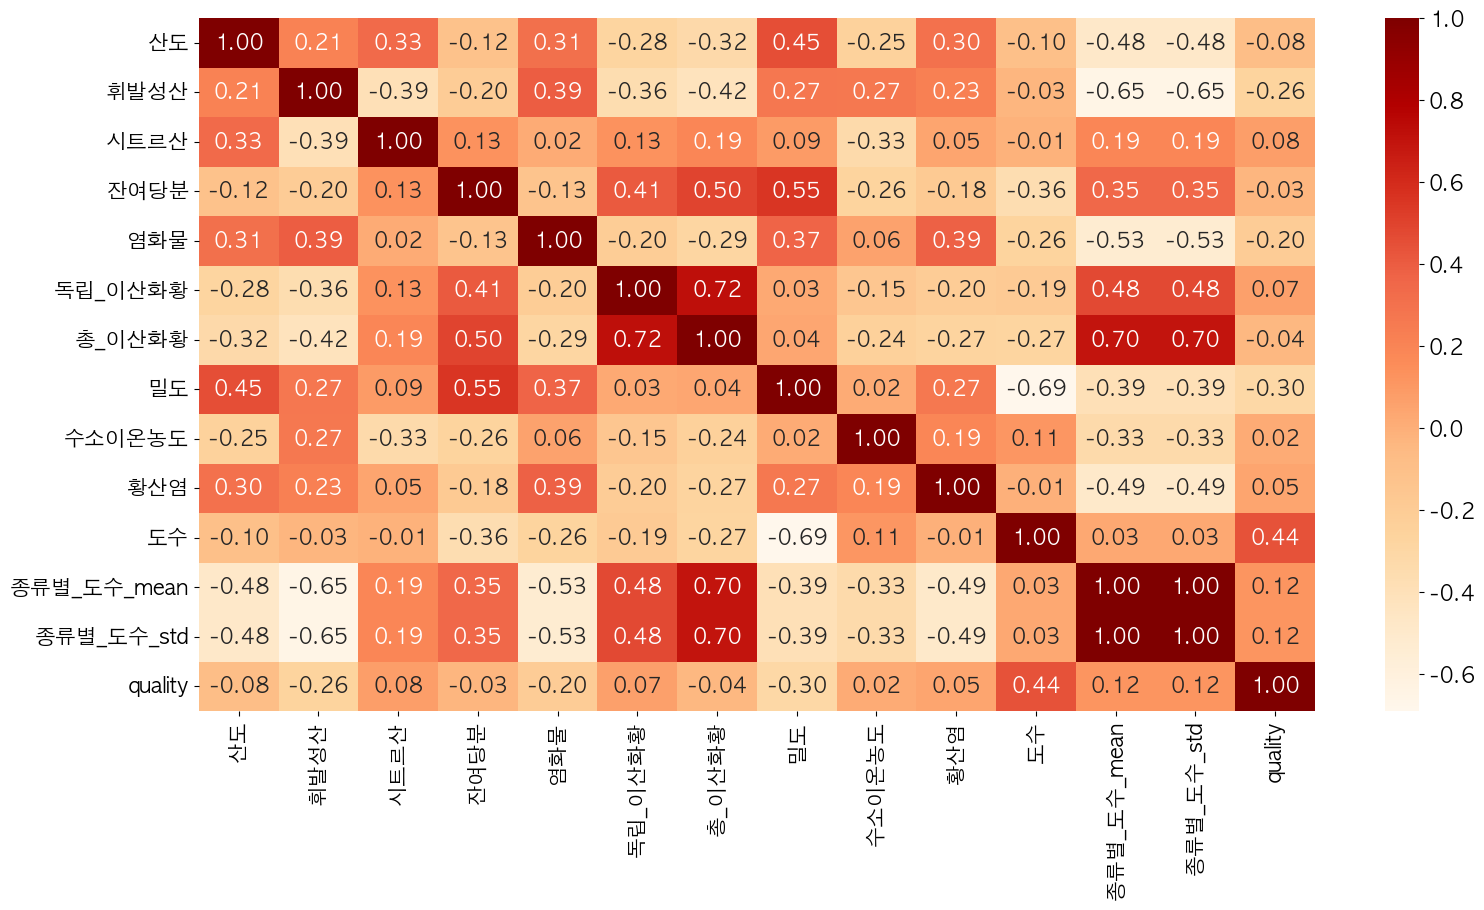

In [4666]:
plt.figure(figsize=(18,9))
sns.heatmap(train.iloc[:,1:].corr(numeric_only=True), annot=True, fmt=".2f", cmap="OrRd")
plt.show()

In [4637]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

# 인코딩

In [4638]:
type_dict = {
    "white":0,
    "red":1
}
train["종류"] = train["종류"].map(type_dict)
test["종류"] = test["종류"].map(type_dict)

# 스케일링

In [4639]:
train_ft = train.iloc[:,1:-1]
test_ft = test.iloc[:,1:]
quality = train["quality"]

train_ft.shape, test_ft.shape

((5483, 20), (1000, 20))

In [4640]:
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()
power_scaler = PowerTransformer()

scalers = [std_scaler, minmax_scaler, robust_scaler, power_scaler]

# 모델링

In [4641]:
rf_model = RandomForestClassifier(random_state=42)
cat_model = CatBoostClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
hgb_model = HistGradientBoostingClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)

models = [rf_model, cat_model, xgb_model, hgb_model, lgbm_model]
models_without_xgb = [rf_model, cat_model, hgb_model, lgbm_model]

## 피처 테스트용

In [4642]:
scores = cross_val_score(rf_model, train_ft, quality, cv = cv_kfold, scoring="accuracy")
scores.mean()

0.6744470653208152

In [3712]:
rf_model.fit(train_ft, quality)
pred = rf_model.predict(test_ft)
submission["quality"] = pred
submission.to_csv("1127_2.csv", index=False)

In [3650]:
# score = []
# for scaler in scalers:
#     train_ft[train_ft.columns] = scaler.fit_transform(train_ft)
#     test_ft[test_ft.columns] = scaler.transform(test_ft)
#     scores = cross_val_score(rf_model, train_ft, quality, scoring="accuracy", cv=cv_kfold)
#     score.append(scores.mean())
# print(f"std_scaler_score: {score[0]}")
# print(f"minmax_scaler_score: {score[1]}")
# print(f"robust_scaler_score: {score[2]}")
# print(f"power_scaler_score: {score[3]}")

std_scaler_score: 0.6779097272588147
minmax_scaler_score: 0.677545096447511
robust_scaler_score: 0.6773629473880324
power_scaler_score: 0.6775459281783764


## 5가지 기본 모델 테스트

In [3679]:
quality_mapping = {3:0, 4:1, 5:2, 6:3, 7:4, 8:5, 9:6}

score = []
for model in models:
    if model is xgb_model:
        xgb_quality = quality.map(quality_mapping)
        scores = cross_val_score(model, train_ft, xgb_quality, scoring="accuracy", cv=cv_kfold)
    else:
        scores = cross_val_score(model, train_ft, quality, scoring="accuracy", cv=cv_kfold)
    score.append(scores.mean())

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/catboost/core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/catboost/core.py", line 2275, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs, graph,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/catboost/core.py", line 1513, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, graph=graph, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/catboost/core.py", line 855, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/catboost/core.py", line 1491, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "_catboost.pyx", line 4339, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4391, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4200, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 3083, in _catboost._set_features_order_data_pd_data_frame
_catboost.CatBoostError: features data: pandas.DataFrame column '산도_등급' has dtype 'category' but is not in  cat_features list


In [3680]:
print(f"rf_model_score: {score[0]}")
print(f"cat_model_score: {score[1]}")
print(f"xgb_model_score: {score[2]}")
print(f"hgb_model_score: {score[3]}")
print(f"lgbm_model_score: {score[4]}")

rf_model_score: 0.6791867668292424


IndexError: list index out of range

## feature importance

<Axes: ylabel='None'>

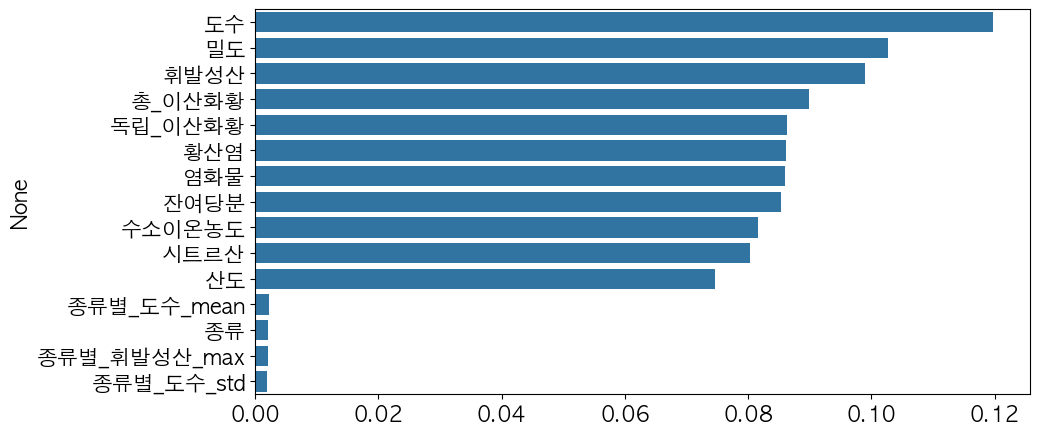

In [2498]:
rf_model.fit(train_ft, quality)
sort_idx = np.argsort(rf_model.feature_importances_)[::-1]

plt.figure(figsize=(10,5))
sns.barplot(y=train_ft.columns[sort_idx], x=rf_model.feature_importances_[sort_idx])

In [2499]:
rf_model.feature_importances_

array([0.07456114, 0.09899807, 0.08031518, 0.08531183, 0.08604566,
       0.08635076, 0.0899303 , 0.1026943 , 0.08164796, 0.08610447,
       0.11979921, 0.00209718, 0.00214841, 0.0019302 , 0.00206531])